In [1]:
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pyautogui
from PIL import ImageGrab

### 1. Test Screen Capture

- Get All Window

In [6]:
windows = pyautogui.getAllTitles()

windows = set([w for w in windows if w != ''])

windows

{'(3) WhatsApp - Google Chrome',
 'Alarms & Clock',
 'Calculator',
 'JupyterLab',
 'Meeting Controls',
 'Microsoft Text Input Application',
 'Program Manager',
 'Settings',
 'ZPToolBarParentWnd',
 'Zoom',
 'croped_face',
 'npm'}

- Screen Capture

In [5]:
window_name = 'Zoom Meeting'

In [7]:
def screen_capture(window_name= 'Zoom Meeting'):
    if window_name not in pyautogui.getAllTitles():
        print("Could not find window name '%s'" % window_name)
        return None
    
    fw = pyautogui.getWindowsWithTitle(window_name)[0]
    fw.maximize()
    pyautogui.click(fw.center)
    fw.activate()

    time.sleep(1)

    sct = ImageGrab.grab() 
    img = np.array(sct)
    
    return img

In [14]:
img = screen_capture(window_name= 'Zoom Meeting')

- Show captured Screen

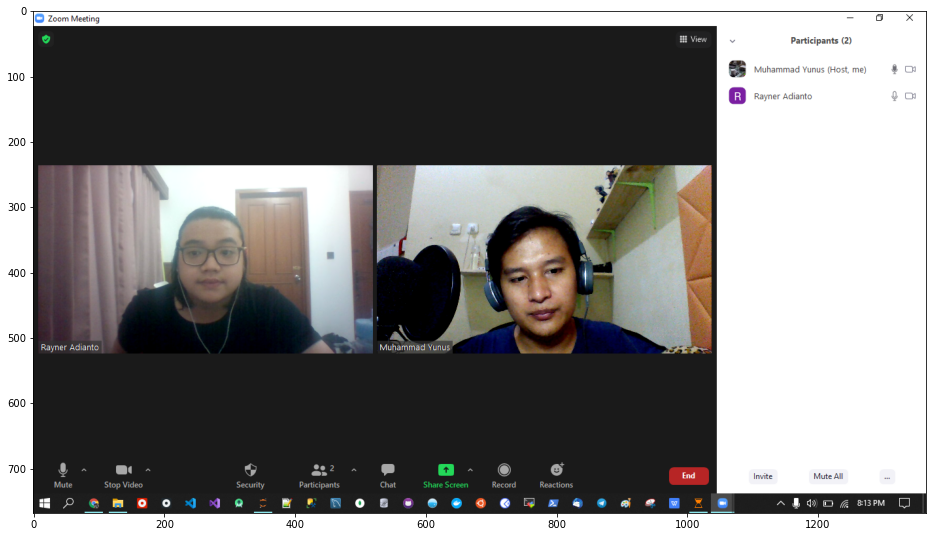

In [15]:
plt.figure(figsize=(16, 10))
plt.imshow(img)

- Test Preprocess Screen Capture

In [16]:
def preprocess(img):
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
    
    img_list = []
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    faces = face_cascade.detectMultiScale(img_gray, 1.3, 5)
    for (x, y, w, h) in faces:
        img_face = img_gray[y:y+h, x:x+w]  # crop face image 
        img_resize = cv2.resize(img_face, (100, 100)) # resize to 100 x 100 pixel
        img_list.append(img_resize)
    return img_list, faces

In [17]:
img_list = preprocess(img)[0]

In [18]:
len(img_list)

2

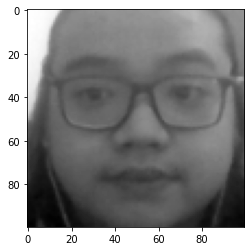

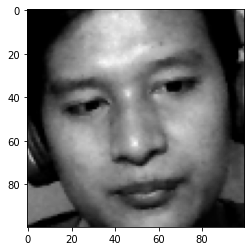

In [20]:
for face in img_list:
    plt.imshow(face, cmap="gray")
    plt.show()

### 2. Load Model PCA

In [21]:
import pickle

def read_model(filename, path=""):
    with open(os.path.join(path, filename), 'rb') as in_name:
        model = pickle.load(in_name)
        return model

In [22]:
from sklearn.decomposition import PCA

In [23]:
pca = read_model("pca_model.pkl")

In [24]:
# convert each detected face to 1D array feature vector
img_list_flatten = [img.flatten() for img in img_list]


# apply PCA to each 1D array feature vector
img_list_pca = pca.transform(img_list_flatten)

In [25]:
img_list_pca[0].shape

(233,)

### 3. load model k-NN

In [26]:
labels = ['Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair', 'Yunus']

In [27]:
from sklearn.neighbors import KNeighborsClassifier

- load model

In [28]:
knn_model = read_model("k-NN_scikit_model.pkl")

- predict data

In [29]:
ids = knn_model.predict(img_list_pca)

In [30]:
ids

array([1, 5], dtype=int64)

In [32]:
label_output = [labels[i] for i in ids]

print("Predicted Name : %s " % label_output[1])

Predicted Name : Yunus 


In [35]:
proba = knn_model.predict_proba(img_list_pca)

confidence = [np.max(p) for p in proba]

print("Confidence : %.3f" % confidence[1])

Confidence : 1.000


In [36]:
proba

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]])

### 4. load model SVM

In [37]:
labels = ['Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair', 'Yunus']

In [38]:
from sklearn.svm import SVC

- load model

In [39]:
model_svm = read_model("SVM_scikit_model.pkl")

- predict data

In [40]:
ids = model_svm.predict(img_list_pca)

In [48]:
label_output = [labels[i] for i in ids]

print("Predicted Name : %s " % label_output[1])

Predicted Name : Gerhard_Schroeder 


In [47]:
proba = model_svm.predict_proba(img_list_pca)

confidence = [np.max(p) for p in proba]

print("Confidence : %.3f" % confidence[1])

Confidence : 0.454


In [49]:
proba

array([[8.35698460e-01, 2.63883105e-02, 1.35267693e-01, 1.29139712e-03,
        8.41260361e-04, 5.12878940e-04],
       [1.43669354e-01, 1.94888654e-02, 1.30677305e-01, 4.54033696e-01,
        1.14521672e-01, 1.37609107e-01]])

___
# Test using Realtime Capture

In [50]:
def draw_ped(img, label, x0, y0, xt, yt, color=(255,127,0), text_color=(255,255,255)):

    (w, h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    cv2.rectangle(img,
                  (x0, y0 + baseline),  
                  (max(xt, x0 + w), yt), 
                  color, 
                  2)
    cv2.rectangle(img,
                  (x0, y0 - h),  
                  (x0 + w, y0 + baseline), 
                  color, 
                  -1)  
    cv2.putText(img, 
                label, 
                (x0, y0),                   
                cv2.FONT_HERSHEY_SIMPLEX,     
                0.5,                          
                text_color,                
                1,
                cv2.LINE_AA) 
    return img

In [52]:
def screen_capture(window_name= 'Zoom Meeting'):
    if window_name not in pyautogui.getAllTitles():
        return None
    try :
        fw = pyautogui.getWindowsWithTitle(window_name)[0]
        fw.maximize()
        pyautogui.click(fw.center)
        fw.activate()
    except :
        pass
    
    time.sleep(1)

    sct = ImageGrab.grab() 
    img = np.array(sct)
    
    return img

In [53]:
def preprocess(img):
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
    
    img_list = []
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    faces = face_cascade.detectMultiScale(img_gray, 1.3, 5)
    for (x, y, w, h) in faces:
        img_face = img_gray[y:y+h, x:x+w]  # crop face image 
        img_resize = cv2.resize(img_face, (100, 100)) # resize to 100 x 100 pixel
        img_list.append(img_resize)
    return img_list, faces

In [ ]:
labels = ['Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair', 'Yunus']

model_svm = read_model("SVM_scikit_model.pkl")


while True:
    # get data     
    img = screen_capture(window_name= 'Zoom Meeting')
    if img is None :
        print("[INFO] could not find window !")
        break
    
    # preprocessing    
    img_list, face_coords = preprocess(img)
    if len(img_list) < 1 :
        print("[INFO] could not find face!")
    else : 
        # convert each detected face to 1D array feature vector
        img_list_flatten = [img.flatten() for img in img_list]

        # apply PCA to each 1D array feature vector
        img_list_pca = pca.transform(img_list_flatten)

        # predict data using SVM    
        ids = model_svm.predict(img_list_pca)
        label_output = [labels[i] for i in ids]

        proba = model_svm.predict_proba(img_list_pca)
        confidence = [np.max(p) for p in proba]

        for i in range(len(ids)):
            plt.imshow(img_list[i], cmap="gray")
            title = "Name : %s (%.2f%%)" % (label_output[i], (confidence[i]*100))
            plt.title(title)
            plt.show()
            
            x, y, w, h = face_coords[i]
            x0, y0, xt, yt = x, y, x+w, y+h
            img = draw_ped(img, title, x0, y0, xt, yt)
            
    cv2.imshow("Facerecognition", img[:,:,::-1])
    if cv2.waitKey(3000) == ord('q'):
        break

cv2.destroyAllWindows()

### Add Toast Windows Notification

In [ ]:
! pip install win10toast

In [59]:
from win10toast import ToastNotifier
toaster = ToastNotifier()
toaster.show_toast("Sample Notification","Python is awesome!!!")

True

- apply to realtime capture

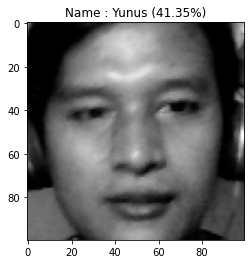

[INFO] could not find face!


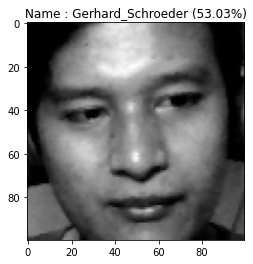

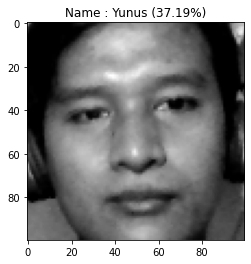

[INFO] could not find face!
[INFO] could not find window !


In [60]:
labels = ['Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair', 'Yunus']

model_svm = read_model("SVM_scikit_model.pkl")

toaster = ToastNotifier()

while True:
    # get data     
    img = screen_capture(window_name= 'Zoom Meeting')
    if img is None :
        print("[INFO] could not find window !")
        break
    
    # preprocessing    
    img_list, face_coords = preprocess(img)
    if len(img_list) < 1 :
        print("[INFO] could not find face!")
    else : 
        # convert each detected face to 1D array feature vector
        img_list_flatten = [img.flatten() for img in img_list]

        # apply PCA to each 1D array feature vector
        img_list_pca = pca.transform(img_list_flatten)

        # predict data using SVM    
        ids = model_svm.predict(img_list_pca)
        label_output = [labels[i] for i in ids]

        proba = model_svm.predict_proba(img_list_pca)
        confidence = [np.max(p) for p in proba]

        for i in range(len(ids)):
            plt.imshow(img_list[i], cmap="gray")
            title = "Name : %s (%.2f%%)" % (label_output[i], (confidence[i]*100))
            plt.title(title)
            plt.show()
            
            x, y, w, h = face_coords[i]
            x0, y0, xt, yt = x, y, x+w, y+h
            img = draw_ped(img, title, x0, y0, xt, yt)
            
            toaster.show_toast("Attendance Systems", title)
            
    cv2.imshow("Facerecognition", img[:,:,::-1])
    if cv2.waitKey(3000) == ord('q'):
        break

cv2.destroyAllWindows()